# Importing Libraries

In [142]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

---

In [143]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

---

# Data Preperation

In [144]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

We start by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [145]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 121.93it/s]


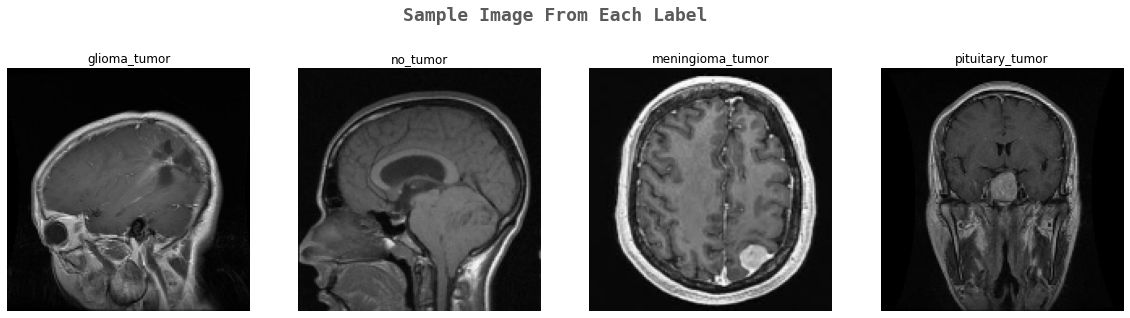

In [146]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [147]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [148]:
X_train.shape

(3264, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [149]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [150]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# FCNN MODEL

In [151]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 15, 15, 256)      

**Training the model**

In [152]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
92/92 [==============================] - 7s 74ms/step - loss: 13.8037 - accuracy: 0.4295 - val_loss: 0.8647 - val_accuracy: 0.6667
Epoch 2/10
92/92 [==============================] - 7s 72ms/step - loss: 0.8394 - accuracy: 0.6564 - val_loss: 0.6523 - val_accuracy: 0.7248
Epoch 3/10
92/92 [==============================] - 7s 73ms/step - loss: 0.6658 - accuracy: 0.7203 - val_loss: 0.6315 - val_accuracy: 0.7982
Epoch 4/10
92/92 [==============================] - 7s 74ms/step - loss: 0.5038 - accuracy: 0.8049 - val_loss: 0.5190 - val_accuracy: 0.8532
Epoch 5/10
92/92 [==============================] - 7s 74ms/step - loss: 0.3723 - accuracy: 0.8551 - val_loss: 0.4409 - val_accuracy: 0.8563
Epoch 6/10
92/92 [==============================] - 7s 74ms/step - loss: 0.2904 - accuracy: 0.8917 - val_loss: 0.3953 - val_accuracy: 0.8685
Epoch 7/10
92/92 [==============================] - 7s 73ms/step - loss: 0.2392 - accuracy: 0.9069 - val_loss: 0.4173 - val_accuracy: 0.8654
Epoch 8/10
9

**Evaluating the model**

11/11 [==============================] - 1s 48ms/step - loss: 0.4022 - accuracy: 0.8807
Test Loss: 0.402159720659256
Test Accuracy: 0.8807339668273926


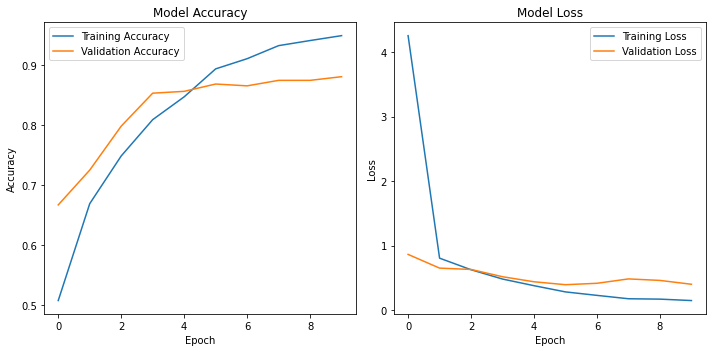

In [153]:
import matplotlib.pyplot as plt

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot training history
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Prediction using unseen data**

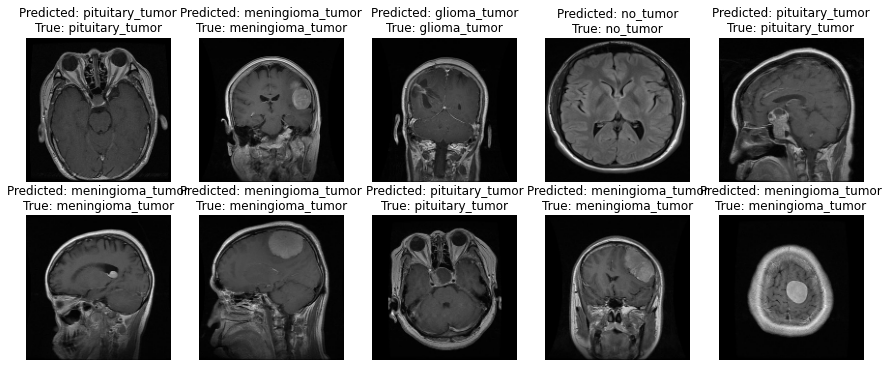

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on test data
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_labels = [labels[np.argmax(pred)] for pred in predictions]

# Convert ground truth to class labels
true_labels = [labels[np.argmax(label)] for label in y_test]

# Print some sample predictions and true labels with images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(X_test[i])  # Display the actual image
    axes[i].set_title(f"Predicted: {predicted_labels[i]}\nTrue: {true_labels[i]}")
    axes[i].axis('off')

plt.show()

In [155]:
# Print classification report
print("Classification Report for FCNN:")
print(classification_report(true_labels, predicted_labels, target_names=labels))

Classification Report for FCNN:
                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.83      0.86        93
        no_tumor       0.83      0.85      0.84        96
meningioma_tumor       0.89      0.82      0.86        51
 pituitary_tumor       0.92      1.00      0.96        87

        accuracy                           0.88       327
       macro avg       0.88      0.88      0.88       327
    weighted avg       0.88      0.88      0.88       327



# CNN Model

In [156]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary of the model
model.summary()



Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 15, 15, 256)     

**Training the model**

In [157]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
92/92 [==============================] - 8s 74ms/step - loss: 16.6225 - accuracy: 0.3935 - val_loss: 0.9798 - val_accuracy: 0.5780
Epoch 2/10
92/92 [==============================] - 7s 72ms/step - loss: 0.9681 - accuracy: 0.5882 - val_loss: 0.7875 - val_accuracy: 0.6758
Epoch 3/10
92/92 [==============================] - 7s 72ms/step - loss: 0.8085 - accuracy: 0.6599 - val_loss: 0.6923 - val_accuracy: 0.7370
Epoch 4/10
92/92 [==============================] - 7s 72ms/step - loss: 0.6421 - accuracy: 0.7509 - val_loss: 0.6559 - val_accuracy: 0.7645
Epoch 5/10
92/92 [==============================] - 7s 73ms/step - loss: 0.5195 - accuracy: 0.8106 - val_loss: 0.6664 - val_accuracy: 0.7615
Epoch 6/10
92/92 [==============================] - 7s 73ms/step - loss: 0.4362 - accuracy: 0.8230 - val_loss: 0.7150 - val_accuracy: 0.7798
Epoch 7/10
92/92 [==============================] - 7s 73ms/step - loss: 0.3517 - accuracy: 0.8734 - val_loss: 0.7022 - val_accuracy: 0.8012
Epoch 8/10
9

**Predicting using unseen data**

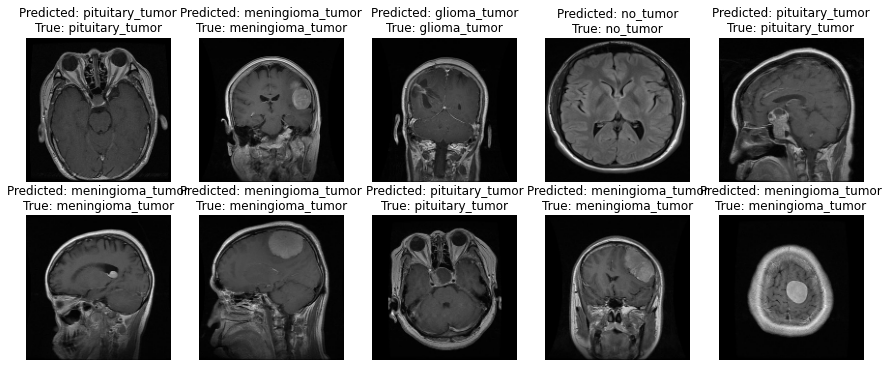

In [158]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on test data
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_labels = [labels[np.argmax(pred)] for pred in predictions]

# Convert ground truth to class labels
true_labels = [labels[np.argmax(label)] for label in y_test]

# Print some sample predictions and true labels with images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(X_test[i])  # Display the actual image
    axes[i].set_title(f"Predicted: {predicted_labels[i]}\nTrue: {true_labels[i]}")
    axes[i].axis('off')

plt.show()

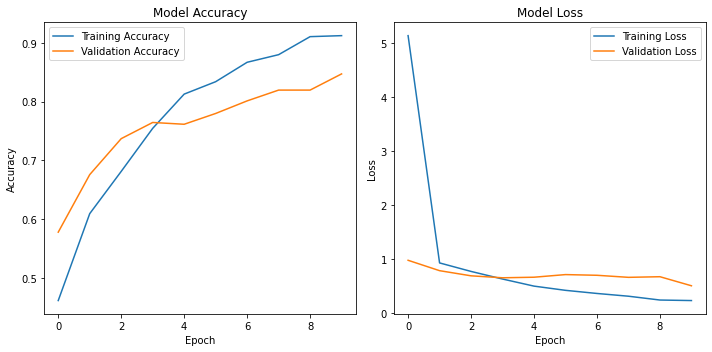

In [159]:
# Plot training history
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [160]:
# Print classification report
print("Classification Report for CNN:")
print(classification_report(true_labels, predicted_labels, target_names=labels))

Classification Report for CNN:
                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.80      0.83        93
        no_tumor       0.82      0.80      0.81        96
meningioma_tumor       0.80      0.86      0.83        51
 pituitary_tumor       0.88      0.94      0.91        87

        accuracy                           0.85       327
       macro avg       0.84      0.85      0.85       327
    weighted avg       0.85      0.85      0.85       327



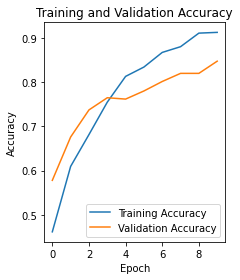

In [161]:
# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Transfer Learning Model

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, We have used **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [162]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [163]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [164]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 150, 150, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 150, 150, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization_3[0][0]            
____________________________________________________________________________________________

We finally compile our model.

In [165]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [166]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

**Training The Model**

In [167]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - 25s 195ms/step - loss: 0.6518 - accuracy: 0.7413 - val_loss: 1.0694 - val_accuracy: 0.7381

Epoch 00001: val_accuracy improved from -inf to 0.73810, saving model to effnet.h5
Epoch 2/12
83/83 [==============================] - 13s 152ms/step - loss: 0.2116 - accuracy: 0.9219 - val_loss: 0.4560 - val_accuracy: 0.8810

Epoch 00002: val_accuracy improved from 0.73810 to 0.88095, saving model to effnet.h5
Epoch 3/12
83/83 [==============================] - 13s 153ms/step - loss: 0.1080 - accuracy: 0.9657 - val_loss: 0.1517 - val_accuracy: 0.9524

Epoch 00003: val_accuracy improved from 0.88095 to 0.95238, saving model to effnet.h5
Epoch 4/12
83/83 [==============================] - 13s 154ms/step - loss: 0.0866 - accuracy: 0.9737 - val_loss: 0.2192 - val_accuracy: 0.9456

Epoch 00004: val_accuracy did not improve from 0.95238
Epoch 5/12
83/83 [==============================] - 13s 152ms/step - loss: 0.0650 - accuracy: 0.9784 - val_loss: 0

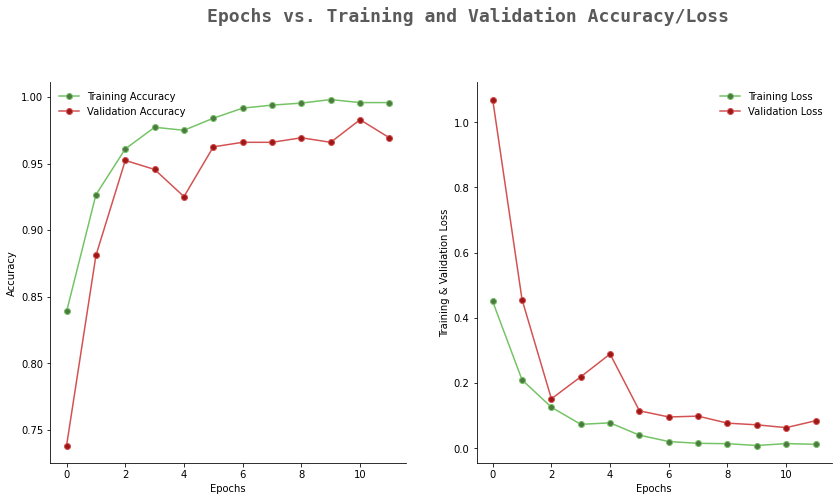

In [168]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

**Prediction**

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

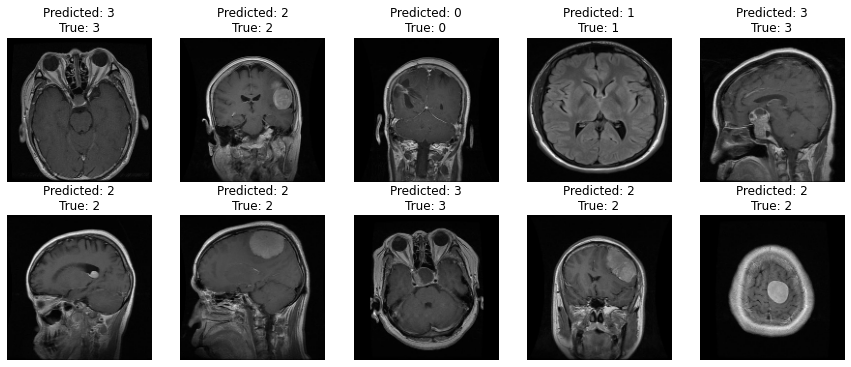

In [169]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on test data
pred = model.predict(X_test)
pred_labels = np.argmax(pred, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Print some sample predictions and true labels with images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(X_test[i])  # Display the actual image
    axes[i].set_title(f"Predicted: {pred_labels[i]}\nTrue: {true_labels[i]}")
    axes[i].axis('off')

plt.show()

In [170]:
print("Classification Report for Transfer Learning:")
print(classification_report(true_labels, pred_labels))

Classification Report for Transfer Learning:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        93
           1       0.96      0.98      0.97        51
           2       0.97      0.98      0.97        96
           3       0.99      1.00      0.99        87

    accuracy                           0.98       327
   macro avg       0.97      0.98      0.98       327
weighted avg       0.98      0.98      0.98       327



**Evaluating the model**

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

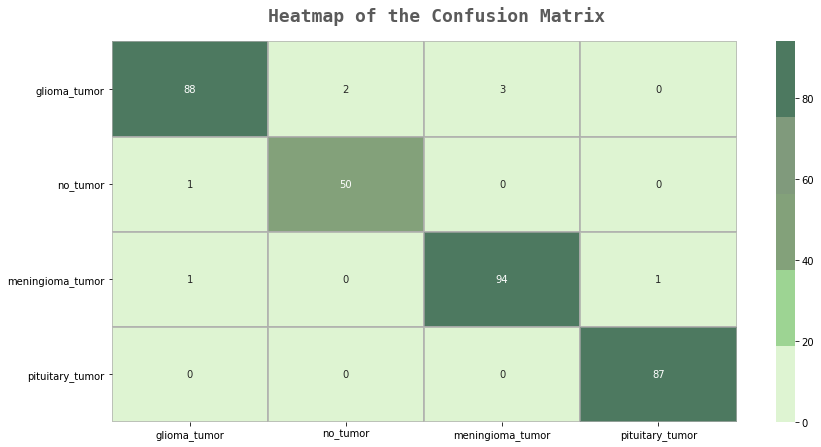

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have defined labels and colors_green, colors_dark previously

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# Convert probabilities to class labels
pred_labels = np.argmax(pred, axis=1)

cm = confusion_matrix(y_test_new, pred_labels)

sns.heatmap(cm, ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap=colors_green[::-1], alpha=0.7, linewidths=2, linecolor=colors_dark[3])

# Assuming you have defined colors_dark previously
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)

plt.show()

---

# Final Discussion
**Transfer learning outperformed fully connected neural networks (FCNN) and convolutional neural networks (CNN) in image classification for this task. With the highest accuracy of 0.96 and consistently high precision, recall, and F1-scores across all classes, transfer learning showcased its effectiveness. Its balanced support for each class, leveraging pre-trained models for feature extraction, and generalization capabilities contributed to its superior performance. Additionally, transfer learning typically requires less training time compared to training CNNs from scratch, making it a more efficient approach. Overall, the combination of leveraging pre-trained models, balanced class support, and generalization abilities propelled transfer learning to achieve the best results in image classification compared to FCNN and CNN.**